### Averaging Active Bets

Each bet is associated with a holding period, defined by the interval \( t1 \), which represents the time between the initial investment idea's generation and the first barrier's hit. 

One approach to managing overlapping bets is to overwrite previous bets with new ones as they arrive. However, this method may lead to excessive portfolio turnover. A more reasonable approach is to average the sizes of all active bets at any given time.

The code below demonstrates one way to implement this approach.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from quant_free.finml.labeling.labeling import *

triple_barrier_event = pd.read_parquet('./research/Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('./research/Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('./research/Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

In [2]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

samples_info_sets = triple_barrier_event.loc[X_train.index].loc[:'2019', 't1']

In [3]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [4]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8641810918774967


In [7]:
triple_barrier_event.loc[X_test.index].loc['2020':, 't1'].head()

Date
2020-01-02   2020-01-09
2020-01-03   2020-01-09
2020-01-06   2020-01-09
2020-01-07   2020-01-09
2020-01-08   2020-01-13
Name: t1, dtype: datetime64[ns]

In [8]:
signal = pd.DataFrame(
    y_pred,
    index = X_test.index,
    columns = ['signal']
)

In [9]:
signal['t1'] = triple_barrier_event.loc[X_test.index].loc['2020':, 't1']

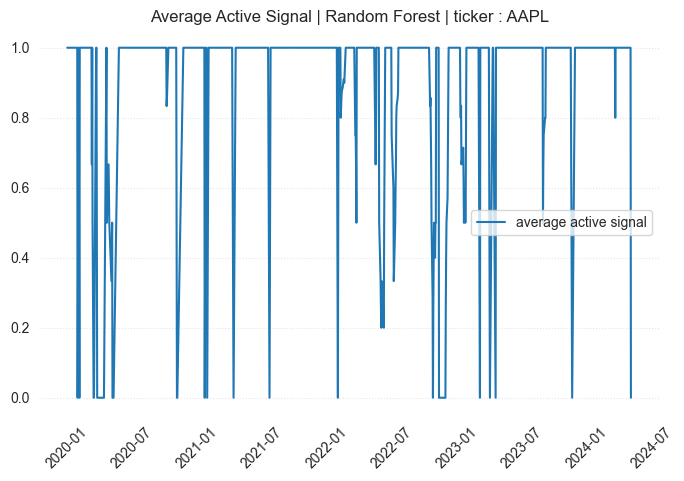

In [13]:
from quant_free.finml.bet_sizing.bet_sizing import avg_active_signals

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    avg_active_signals(signal),
    label = 'average active signal'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Average Active Signal | Random Forest | ticker : AAPL')
plt.show()

### Size Discretization

While averaging can reduce unnecessary portfolio turnover to some extent, small trades may still be triggered for every prediction. This irregular activity can cause unnecessary over-trading. To mitigate this, it is proposed to discretize bet sizes using:

$
m^* = \text{round} \left[ \frac{m}{d}\right]d
$

where $ d \in (0, 1] $. 

The figure below illustrates the discretization of bet sizes.

In [24]:
from quant_free.finml.bet_sizing.bet_sizing import discrete_signal

z_values = np.linspace(-3, 3, 1000)
step_size = 0.2
discretized_signal = discrete_signal(z_values, step_size)

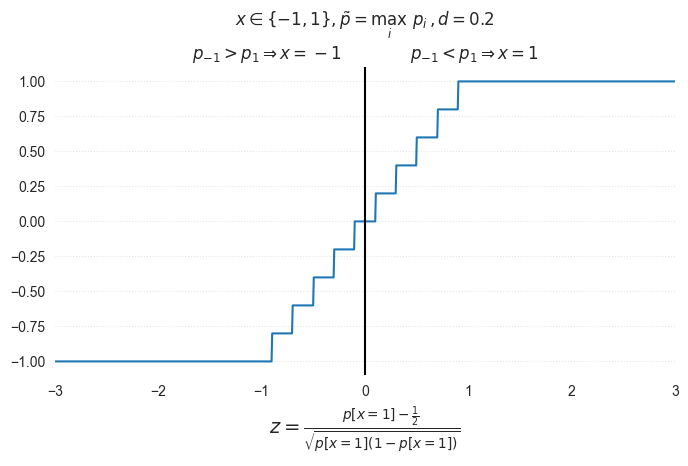

In [25]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(z_values, discretized_signal)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlim(-3, 3)
plt.ylim(-1.1, 1.1)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel(r'$z = \frac{p[x=1] - \frac{1}{2}}{\sqrt{p[x=1](1 - p[x=1])}}$', fontsize=14)
plt.title(r'$x \in \{-1, 1\}, \tilde{p} = \max_i ~ p_i, d = 0.2$' + '\n' + r'$p_{-1} > p_1 \Rightarrow x = -1$' + '\t' + '\t' + r'$p_{-1} < p_1 \Rightarrow x = 1$')
plt.show()